In [1]:
from kernel_est_funcs import *
import numpy as np

In [2]:
spikes = np.load("spikes-10e4-ms.npy")

In [4]:
#tau = 100 #ms
#calcium_signal = sim_calcium(spikes, tau)
savgol_win_len =51

methods = ['pure_fit', 'iqr_outlier', 'ransac_outlier', 'zscore_outlier']
tau_sim = np.array([10, 20, 50, 100, 200, 300, 500, 800, 1000, 
                    1500, 2000, 3000, 5000, 8000, 10000])

tau_est_pure_fit = np.zeros(tau_sim.size)
tau_est_iqr_outlier = np.zeros(tau_sim.size)
tau_est_ransac_outlier = np.zeros(tau_sim.size)
tau_est_zscore_outlier = np.zeros(tau_sim.size)
tau_est_iqr_ransac = np.zeros(tau_sim.size)

for names in methods:
    method = globals()[names]
    counter = 0
    for i in tau_sim:
        calcium_signal = sim_calcium(spikes, i)
        signal, deriv = smoothed_signals(calcium_signal, savgol_win_len)
        var_name = 'tau_est_'+names
        globals()[var_name][counter] = -1/method(signal, deriv)
        counter +=1

next 2 blocks are for combination of iqr and ransac

In [6]:
def iqr_outlier_output(signal, deriv, threshold=1.5):
    
    x = np.array(signal)
    y = np.array(deriv)

    residuals = y - np.polyval(np.polyfit(x, y, 1), x)
    quartile_1, quartile_3 = np.percentile(residuals, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)

    inlier_x = x[mask]
    inlier_y = y[mask]

    return inlier_x, inlier_y

In [7]:
counter = 0
for i in tau_sim:
        calcium_signal = sim_calcium(spikes, i)
        signal, deriv = smoothed_signals(calcium_signal, savgol_win_len)
        x_iqr, y_iqr = iqr_outlier_output(signal, deriv)
        tau_est_iqr_ransac[counter] = ransac_outlier(x_iqr, y_iqr)
        counter +=1

Plotting comarison of outlier removal methods

In [11]:
%matplotlib qt
fig, ax = plt.subplots()

ax.plot(tau_sim, tau_est_pure_fit, 'o-', label='with outliers')
ax.plot(tau_sim, tau_est_iqr_outlier, 'o-', label='IQR')
ax.plot(tau_sim, tau_est_ransac_outlier, 'o-', label= 'RANSAC')
ax.plot(tau_sim, tau_est_zscore_outlier, 'o-', label='Z score')
#ax.plot(tau_sim, tau_est_iqr_ransac, 'o-', label='IQR-RASNAC')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

In [36]:
x = np.arange(len(tau_sim))
y1 = abs(tau_sim - tau_est_pure_fit)
y2 = abs(tau_sim - tau_est_iqr_outlier)
y3 = abs(tau_sim - tau_est_zscore_outlier)
y4 = abs(tau_sim - tau_est_ransac_outlier)
#y5 = abs(tau_sim - tau_est_iqr_ransac)
bar_width = 0.2
tau_sim_str = tau_sim.astype(str)

fig2, ax2 = plt.subplots()

ax2.bar(x-bar_width, y1, width=bar_width, label='with outliers')
ax2.bar(x, y2, width=bar_width, label='IQR')
ax2.bar(x+bar_width, y3, width=bar_width, label='Z Score')
ax2.bar(x+2*bar_width, y4, width=bar_width, label='RANSAC')
#ax2.bar(x+3*bar_width, y5, width=bar_width)
ax2.set_xticks(x, tau_sim_str)
ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel('signals time constant in ms')
ax2.set_ylabel('error of estimated time constant')

Text(0, 0.5, 'error of estimated time constant')

Plot of outliers

In [3]:
cal = sim_calcium(spikes)
win_len = 51
signal, deriv = smoothed_signals(cal, win_len)

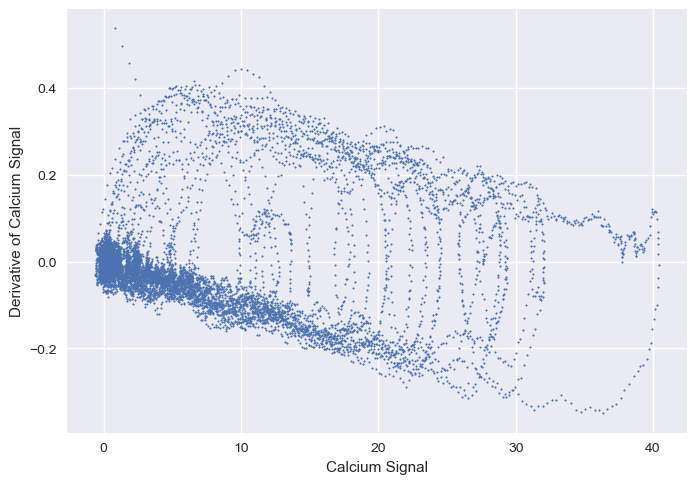

In [4]:
scatter_all(cal, win_len)

-0.006684508049888912

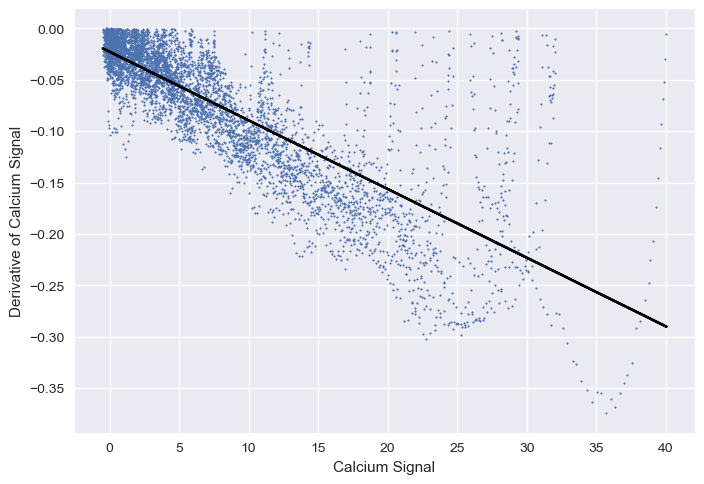

In [5]:
cal = sim_calcium(spikes)
win_len =51
signal, deriv = smoothed_signals(cal, 51)
pure_fit(signal, deriv, True)

-0.007944413760381328

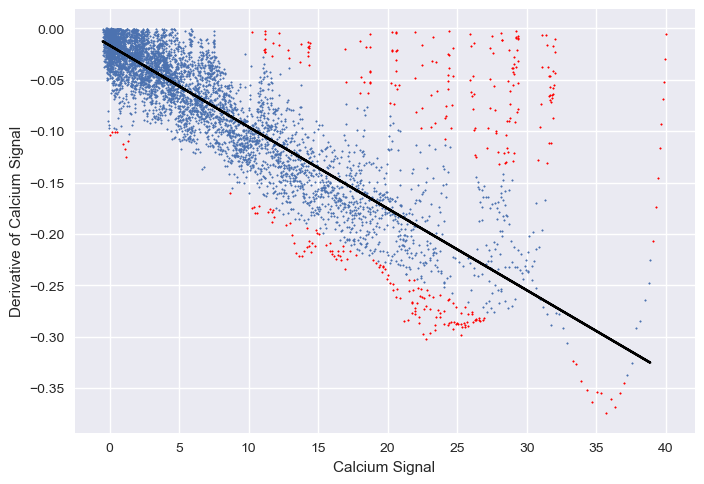

In [6]:
iqr_outlier(signal, deriv, do_plot=True)

-0.00931107399119935

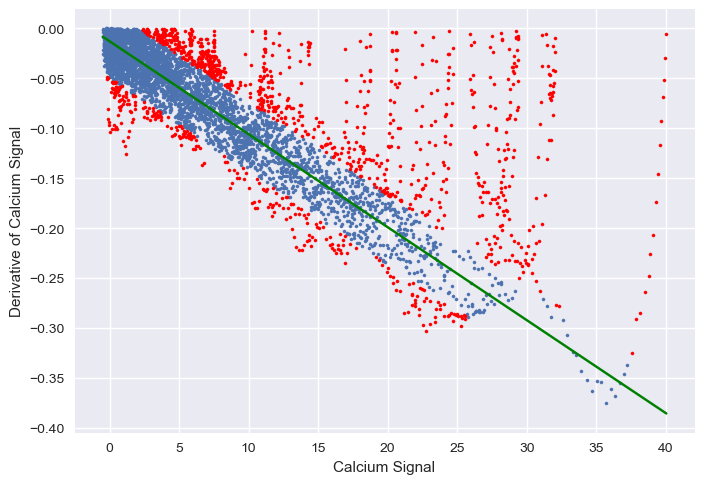

In [7]:
ransac_outlier(signal, deriv, do_plot=True)

-0.007552902616232586

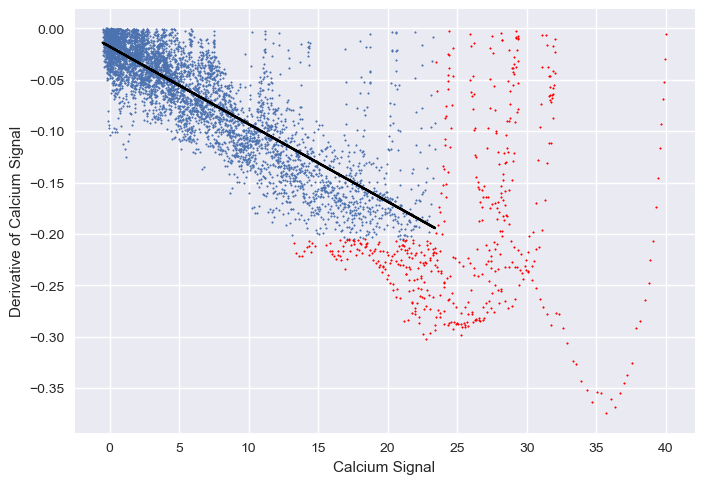

In [8]:
zscore_outlier(signal, deriv, do_plot=True)